#### Set up Dataset - A binary subset of CIFAR 10

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import DenseNet121, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a binary subset for classes 'cat' (label 3) and 'dog' (label 5)
binary_classes = [3, 5]
train_filter = np.isin(y_train, binary_classes).reshape(-1)
test_filter = np.isin(y_test, binary_classes).reshape(-1)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Map labels to binary (0 and 1)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Resize images to match input size for pretrained models (224x224)
IMG_SIZE = (224, 224)

# Resizing function for CIFAR-10 images
def preprocess_images(images):
    return np.array([tf.image.resize(image, IMG_SIZE).numpy() for image in images])

x_train_resized = preprocess_images(x_train)
x_test_resized = preprocess_images(x_test)


In [4]:
x_train_resized.shape

(10000, 224, 224, 3)

#### Preprocessing and Augmentation

In [5]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow(x_train_resized, y_train, batch_size=32)
test_gen = test_datagen.flow(x_test_resized, y_test, batch_size=32)

#### Creating Models
* DenseNet121
* VGG16
* InceptionResNetV2

In [6]:
def create_model(base_model_class, input_shape=(224, 224, 3)):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Initialize models
densenet_model = create_model(DenseNet121)
vgg_model = create_model(VGG16)
inception_resnet_model = create_model(InceptionResNetV2)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Danger cell
epochs = 50
learning_rate = 1e-4
patience = 5

# Function to compile, train, and return training history
def compile_and_train(model, train_gen, val_gen, epochs, learning_rate, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', monitor='val_accuracy', save_best_only=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history

# Train each model and collect histories
densenet_history = compile_and_train(densenet_model, train_gen, test_gen, epochs, learning_rate, 'DenseNet121')
vgg_history = compile_and_train(vgg_model, train_gen, test_gen, epochs, learning_rate, 'VGG16')
inception_resnet_history = compile_and_train(inception_resnet_model, train_gen, test_gen, epochs, learning_rate, 'InceptionResNetV2')


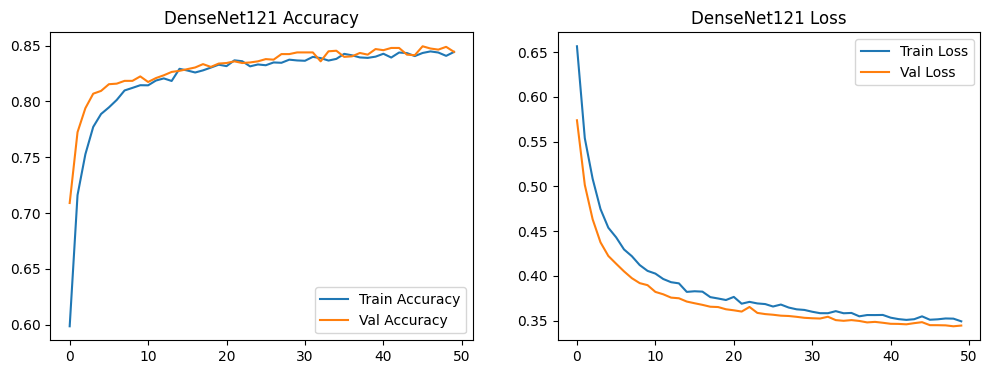

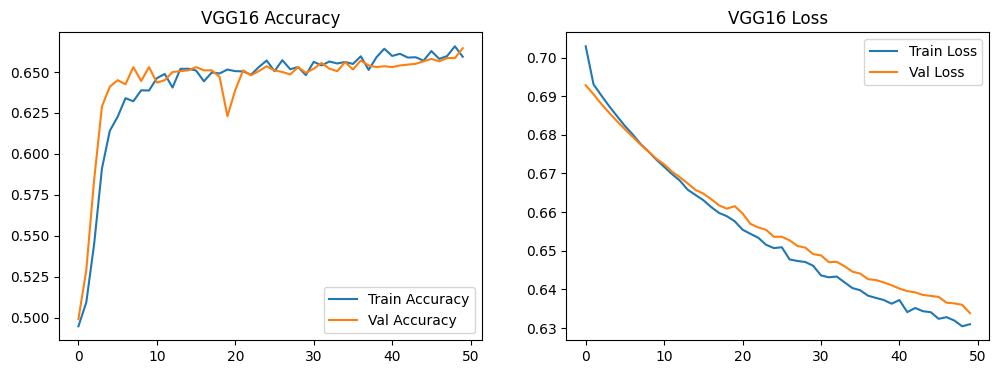

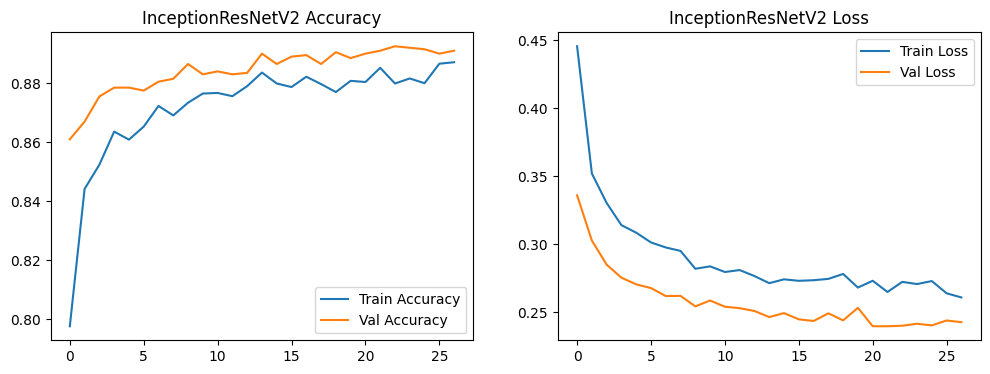

In [8]:
# Plot function for learning curves
def plot_learning_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.legend()

    plt.show()

# Display learning curves for each model
plot_learning_curves(densenet_history, 'DenseNet121')
plot_learning_curves(vgg_history, 'VGG16')
plot_learning_curves(inception_resnet_history, 'InceptionResNetV2')


In [9]:
# Function to calculate evaluation metrics and format results
def get_evaluation_metrics(model, test_gen, name):
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
    return {'Model': name, 'Test Loss': test_loss, 'Test Accuracy': test_accuracy}

# List of models to evaluate with their names
models_to_evaluate = [
    (densenet_model, 'DenseNet121'),
    (vgg_model, 'VGG16'),
    (inception_resnet_model, 'InceptionResNetV2')
]

# Evaluate each model and collect metrics
evaluation_results = [get_evaluation_metrics(model, name) for model, name in models_to_evaluate]

# Convert results to a DataFrame and display
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)


               Model  Test Accuracy  Test Loss
0        DenseNet121         0.8490   0.343570
1              VGG16         0.6645   0.633844
2  InceptionResNetV2         0.8910   0.239528


### Major Differences
1. CIFAR-10 Dataset with 2 classes - Cats and Dogs
2. Models used:  DenseNet121, VGG16 ,InceptionResNetV2
3. Best Model: Inception, 89.10 %